Plot how mean force constant values change during learning.

In [6]:
from openff.toolkit import ForceField
import torch
from pathlib import Path
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns
from openff import units
from pint import Unit
from smee import TensorForceField
from tqdm import tqdm
import loguru
from copy import deepcopy

logger = loguru.logger

plt.style.use("ggplot")

# Mainly written by Josh Horton
def pt_ff_to_off_ff(base_force_field: ForceField, tensor_force_field: TensorForceField) -> ForceField:
    """Convert the FF from pt to OFF ForceField format."""

    # Copy the base force field to avoid modifying it
    base_force_field = deepcopy(base_force_field)

    for potential in tensor_force_field.potentials:
        potential_type = potential.type

        parameter_names = potential.parameter_cols
        parameter_units = potential.parameter_units

        if potential_type in ["Bonds", "Angles"]:
            handler = base_force_field.get_parameter_handler(potential_type)
            for i in range(len(potential.parameters)):
                smirks = potential.parameter_keys[i].id
                ff_parameter = handler[smirks]
                opt_parameters = potential.parameters[i].detach().cpu()
                for j, (p, unit) in enumerate(zip(parameter_names, parameter_units)):
                    setattr(ff_parameter, p, opt_parameters[j] * unit)
        
        if potential_type in ["LinearBonds", "LinearAngles"]:
            handler = base_force_field.get_parameter_handler(potential_type.replace("Linear", ""))
            for i in range(len(potential.parameters)):
                smirks = potential.parameter_keys[i].id
                ff_parameter = handler[smirks]
                opt_linear_parameters = potential.parameters[i].detach().cpu()
                # Convert linear parameters back to harmonic parameters
                k1, k2 = opt_linear_parameters[0].item(), opt_linear_parameters[1].item()
                b1, b2 = opt_linear_parameters[2].item(), opt_linear_parameters[3].item()
                k = k1 + k2
                b = (b1 * k1 + b2 * k2) / k
                # logger.info(f"Converting {smirks} from linear to harmonic")
                # logger.info(f"Parameter names: {parameter_names}")
                if potential_type == "LinearBonds":
                    ff_parameter.k = k * parameter_units[0]
                    ff_parameter.length = b * parameter_units[2]
                elif potential_type == "LinearAngles":
                    # Convert to kcal mol-1 deg -2 (from kcal mol-1 rad -2)
                    ff_parameter.k = k * parameter_units[0]
                    ff_parameter.angle = b * parameter_units[2]
        
        elif potential_type in ["ProperTorsions"]:
            handler = base_force_field.get_parameter_handler(potential_type)
            # we need to collect the k values into a list accross the entries
            collection_data = {}
            for i in range(len(potential.parameters)):
                smirks = potential.parameter_keys[i].id
                if smirks not in collection_data:
                    collection_data[smirks] = {}
                opt_parameters = potential.parameters[i].detach().cpu()
                # find k and the perodicity
                k_index = parameter_names.index('k')
                k = opt_parameters[k_index] * parameter_units[k_index]
                p = int(opt_parameters[parameter_names.index('periodicity')])
                collection_data[smirks][p] = k
            # now update the force field
            for smirks, tor_data in collection_data.items():
                ff_parameter = handler[smirks]
                k_s = [tor_data[p] for p in ff_parameter.periodicity]
                # logger.info(ff_parameter.periodicity)
                # logger.info(k_s)
                # logger.info(smirks)
                ff_parameter.k = k_s

        elif potential_type in ["ImproperTorsions"]:
            handler = base_force_field.get_parameter_handler(potential_type)
            # we only fit the v2 terms for impropers so convert to list and set
            for i in range(len(potential.parameters)):
                smirks = potential.parameter_keys[i].id
                opt_parameters = potential.parameters[i].detach().cpu()
                k_index = parameter_names.index('k')
                ff_parameter = handler[smirks]
                ff_parameter.k = [opt_parameters[k_index] * parameter_units[k_index]]

    return base_force_field


In [2]:
spice2_linear_harm = ForceField("lj-sage-msm-0-torsions-linear-harm-trained-1000-epoch-spice2.offxml")
spice2 = ForceField("spice-2-lj-sage-2-2-msm-expanded-torsions.offxml")

In [3]:
# test_pt_ff_path = Path("../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-100.pt")
# pt_ff = torch.load(test_pt_ff_path)
# [p.type for p in pt_ff.potentials]

In [2]:
def get_param_values(force_field: ForceField, potential_type: str, parameter_key: str) -> tuple[list[str], Unit, npt.NDArray[np.float64]]:
    """Get the values of a parameter for a given potential type and parameter key."""

    params = force_field.get_parameter_handler(potential_type).parameters
    param_names = [f"{p.id}_{parameter_key}" for p in params]
    param_vals_with_units = [p.to_dict()[parameter_key] for p in params]
    param_units = units.unit.degrees if potential_type == "Angles" and parameter_key == "angle" else param_vals_with_units[0].units
    param_vals_unitless = np.array([float(v / param_units) for v in param_vals_with_units], dtype=np.float64)

    return param_names, param_units, param_vals_unitless

In [3]:
def get_rms_param_values(force_fields: list[ForceField], potential_type: str, parameter_key: str) -> tuple[Unit, npt.NDArray[np.float64]]:
    """Get the rms values of a parameter for a given potential type and parameter key."""

    param_vals_rmss = []
    param_units = None

    for ff in force_fields:
        _, units, vals = get_param_values(ff, potential_type, parameter_key)
        if param_units is None:
            param_units = units
        param_vals_rms = np.sqrt(np.mean(vals**2))
        param_vals_rmss.append(param_vals_rms)

    return param_units, np.array(param_vals_rmss, dtype=np.float64)

In [45]:
def plot_param_trajectories(
    force_fields: dict[str, list[ForceField]],
    pot_types_and_param_keys: list[tuple[str, str]] = [
        ("Bonds", "k"),
        ("Bonds", "length"),
        ("Angles", "k"),
        ("Angles", "angle"),
        ("ProperTorsions", "k1"),
        ("ProperTorsions", "k2"),
        ("ProperTorsions", "k3"),
        ("ProperTorsions", "k4"),
        ("ImproperTorsions", "k1"),
    ],
) -> tuple[plt.Figure, list[plt.Axes]]:
    """Plot the parameter trajectories for a given set of potential types and parameter keys."""

    # One axis for each potential type/ parameter key pair
    fig, axes = plt.subplots(
        nrows=len(pot_types_and_param_keys),
        ncols=1,
        figsize=(7, 4 * len(pot_types_and_param_keys)),
    )
    
    axes = axes.flatten() if len(pot_types_and_param_keys) > 1 else [axes]

    for i, (pot_type, param_key) in enumerate(pot_types_and_param_keys):
        
        for ff_name, force_fields_list in force_fields.items():
            param_units, rmse_param_vals = get_rms_param_values(force_fields_list, pot_type, param_key)

            axes[i].plot(
                range(len(force_fields_list)),
                rmse_param_vals,
                marker="o",
                label=ff_name,
            )

        axes[i].set_ylabel(f"RMS {pot_type} {param_key}\n({param_units})")
        axes[i].set_xlabel("Epoch")
        axes[i].set_title(f"{pot_type} {param_key} RMS Trajectory")
        axes[i].set_xticks(range(len(force_fields_list)))
        # Set x tick labels to be the epoch numbers (100 times the index)
        axes[i].set_xticklabels([f"{i * 100}" for i in range(len(force_fields_list))])
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        # axes[i].grid()

    fig.tight_layout()

    return fig, axes

In [5]:
def get_xml_ffs(training_dir: Path, base_ff: ForceField) -> list[ForceField]:
    """Plot the parameter trajectories for a given training directory."""

    # Load the force fields
    ff_files = training_dir.glob("*.pt")
    # Ignore any files that are not in the format "force-field-epoch-<number>.pt"
    ff_files = [ff for ff in ff_files if "force-field-epoch" in ff.stem]
    # Sort by the training number
    ff_files = sorted(ff_files, key=lambda x: int(x.stem.split("-")[-1]))
    # Only include every 100th file
    ff_files = [ff_file for ff_file in ff_files if int(ff_file.stem.split("-")[-1]) % 100 == 0]
    print(ff_files)

    xml_ffs = [pt_ff_to_off_ff(base_ff, torch.load(ff)) for ff in tqdm(ff_files)]

    return xml_ffs

In [13]:
base_ff = ForceField("spice-2-lj-sage-2-2-msm-expanded-torsions.offxml")
xml_ffs = {"spice2": get_xml_ffs(Path("../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547"), base_ff) ,
           "spice2_lin_harm": get_xml_ffs(Path("../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/"), base_ff),
           "spice2_lin_harm_reg": get_xml_ffs(Path("../fits/spice2_linearised_harmonics_improper_reg"), base_ff),
        }

[PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-0.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-100.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-200.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-300.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-400.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-500.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-600.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-700.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-800.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-900.pt')]


100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


[PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-0.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-100.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-200.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-300.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-400.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-500.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-600.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-700.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-800.pt'), Po

100%|██████████| 10/10 [01:04<00:00,  6.47s/it]


[PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-0.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-100.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-200.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-300.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-400.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-500.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-600.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-700.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-800.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-900.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-1000.pt')]


100%|██████████| 11/11 [01:16<00:00,  6.98s/it]


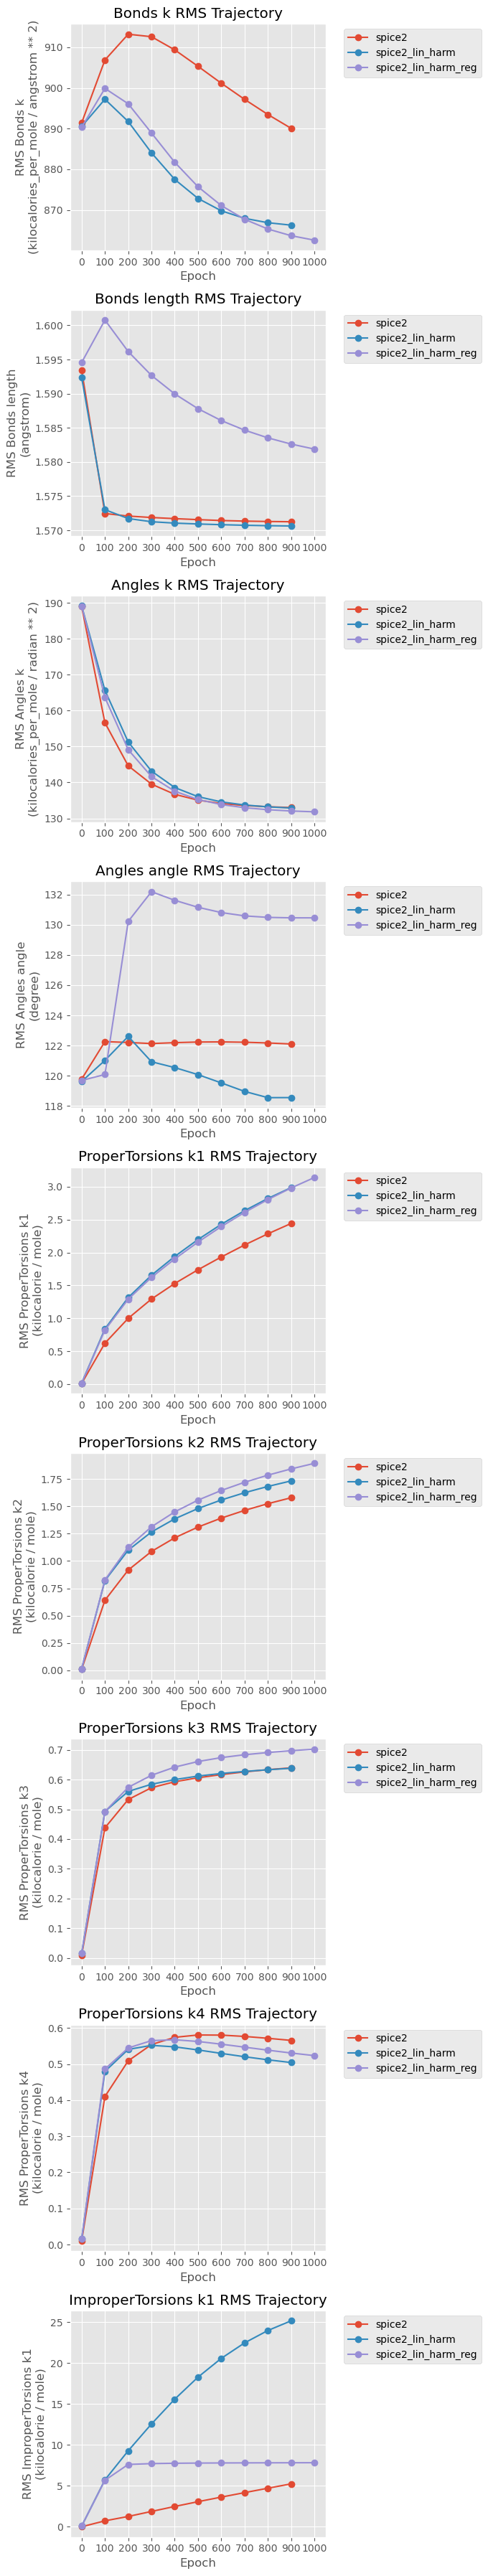

In [46]:
fig, axes = plot_param_trajectories(xml_ffs)
fig.savefig("spice2_training_param_trajectories.png", dpi=300, bbox_inches="tight")

In [8]:
base_ff = ForceField("spice-2-lj-sage-2-2-msm-expanded-torsions.offxml")
xml_ffs = get_xml_ffs(Path("../fits/spice2_linearised_harmonics_improper_reg"), base_ff)

[PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-0.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-100.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-200.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-300.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-400.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-500.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-600.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-700.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-800.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-900.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-1000.pt')]


  0%|          | 0/11 [00:00<?, ?it/s]2025-05-12 19:11:20.254 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]~[#6X3:2]~[*:3] from linear to harmonic
2025-05-12 19:11:20.256 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'angle2')
2025-05-12 19:11:20.258 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]~[#6X4:2]-[*:3] from linear to harmonic
2025-05-12 19:11:20.258 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'angle2')
2025-05-12 19:11:20.259 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]~[#7X4,#7X3,#7X2-1:2]~[*:3] from linear to harmonic
2025-05-12 19:11:20.259 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'angle2')
2025-05-12 19:11:20.259 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]-[#8:2]-[*:3] from linear to harmonic
2025-05-12 19:11:20.260 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'a

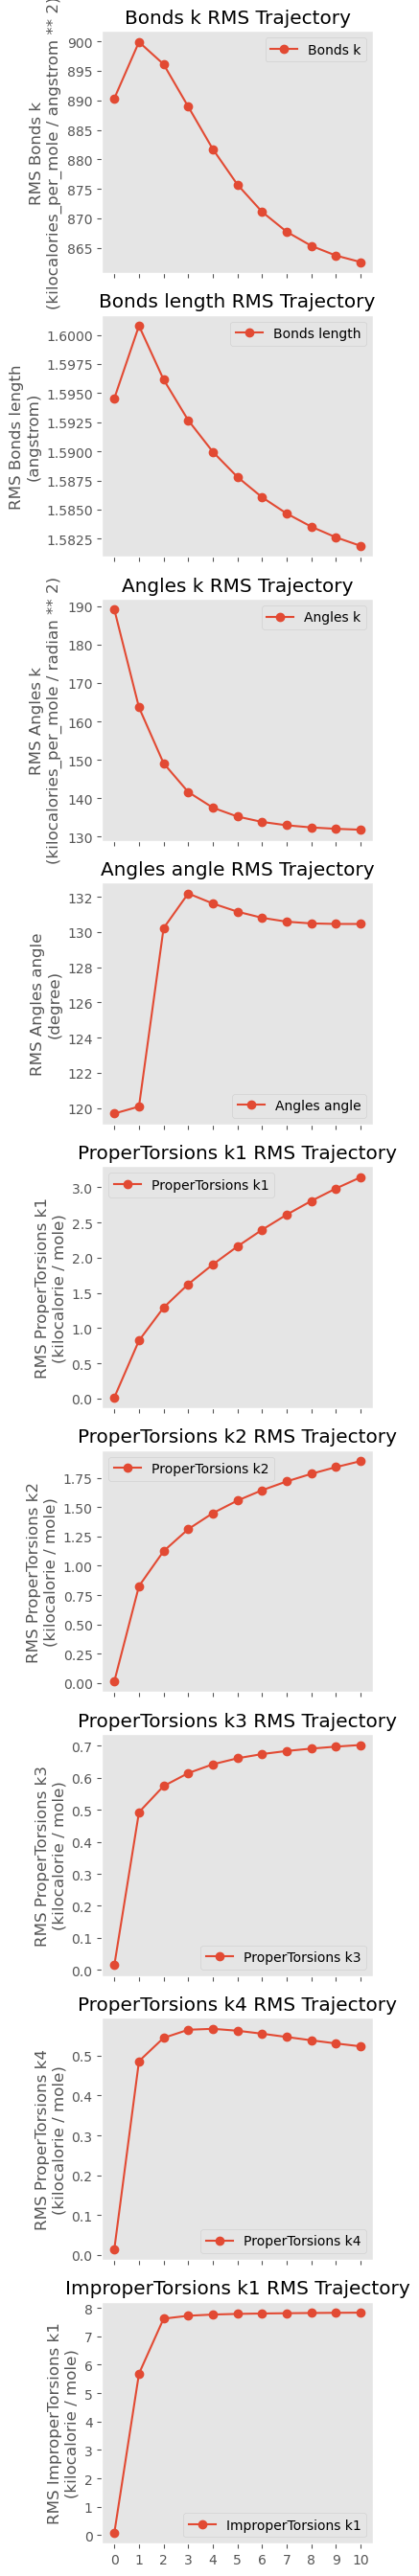

In [9]:
fig,axes = plot_param_trajectories(xml_ffs)
fig.savefig("spice2_linearised_harmonics_improper_reg_param_trajectories.png", dpi=300, bbox_inches="tight")

In [10]:
!ls ../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/

config.yaml
events.out.tfevents.1744980617.sage-303395
final-force-field.pt
force-field-epoch-0.pt
force-field-epoch-100.pt
force-field-epoch-10.pt
force-field-epoch-110.pt
force-field-epoch-120.pt
force-field-epoch-130.pt
force-field-epoch-140.pt
force-field-epoch-150.pt
force-field-epoch-160.pt
force-field-epoch-170.pt
force-field-epoch-180.pt
force-field-epoch-190.pt
force-field-epoch-200.pt
force-field-epoch-20.pt
force-field-epoch-210.pt
force-field-epoch-220.pt
force-field-epoch-230.pt
force-field-epoch-240.pt
force-field-epoch-250.pt
force-field-epoch-260.pt
force-field-epoch-270.pt
force-field-epoch-280.pt
force-field-epoch-290.pt
force-field-epoch-300.pt
force-field-epoch-30.pt
force-field-epoch-310.pt
force-field-epoch-320.pt
force-field-epoch-330.pt
force-field-epoch-340.pt
force-field-epoch-350.pt
force-field-epoch-360.pt
force-field-epoch-370.pt
force-field-epoch-380.pt
force-field-epoch-390.pt
force-field-epoch-400.pt
force-field-epoch-40.pt
force-field-epoch-410.pt
force

In [11]:
xml_ffs = get_xml_ffs(Path("../../.."), base_ff)

[]


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [12]:
base_ff = ForceField("spice-2-lj-sage-2-2-msm-expanded-torsions.offxml")
xml_ffs = get_xml_ffs(Path("../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/"), base_ff)

[PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-0.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-100.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-200.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-300.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-400.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-500.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-600.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-700.pt'), PosixPath('../../../SPICE-SMEE/fit-v5/fits/expanded_tor_linear/fit-20250418-135017/force-field-epoch-800.pt'), Po

  0%|          | 0/10 [00:00<?, ?it/s]2025-05-12 19:12:37.244 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]~;!@[*;X3;r5:2]~;@[*;r5:3] from linear to harmonic
2025-05-12 19:12:37.245 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'angle2')
2025-05-12 19:12:37.247 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]~[#6X3:2]~[*:3] from linear to harmonic
2025-05-12 19:12:37.248 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'angle2')
2025-05-12 19:12:37.248 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*;r5:1]1@[*;r5:2]@[*;r5:3]@[*;r5]@[*;r5]1 from linear to harmonic
2025-05-12 19:12:37.248 | INFO     | __main__:pt_ff_to_off_ff:53 - Parameter names: ('k1', 'k2', 'angle1', 'angle2')
2025-05-12 19:12:37.249 | INFO     | __main__:pt_ff_to_off_ff:52 - Converting [*:1]~[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]~[*:3] from linear to harmonic
2025-05-12 19:12:37.249 | INFO     | __main__:pt_ff_to_off_ff:5

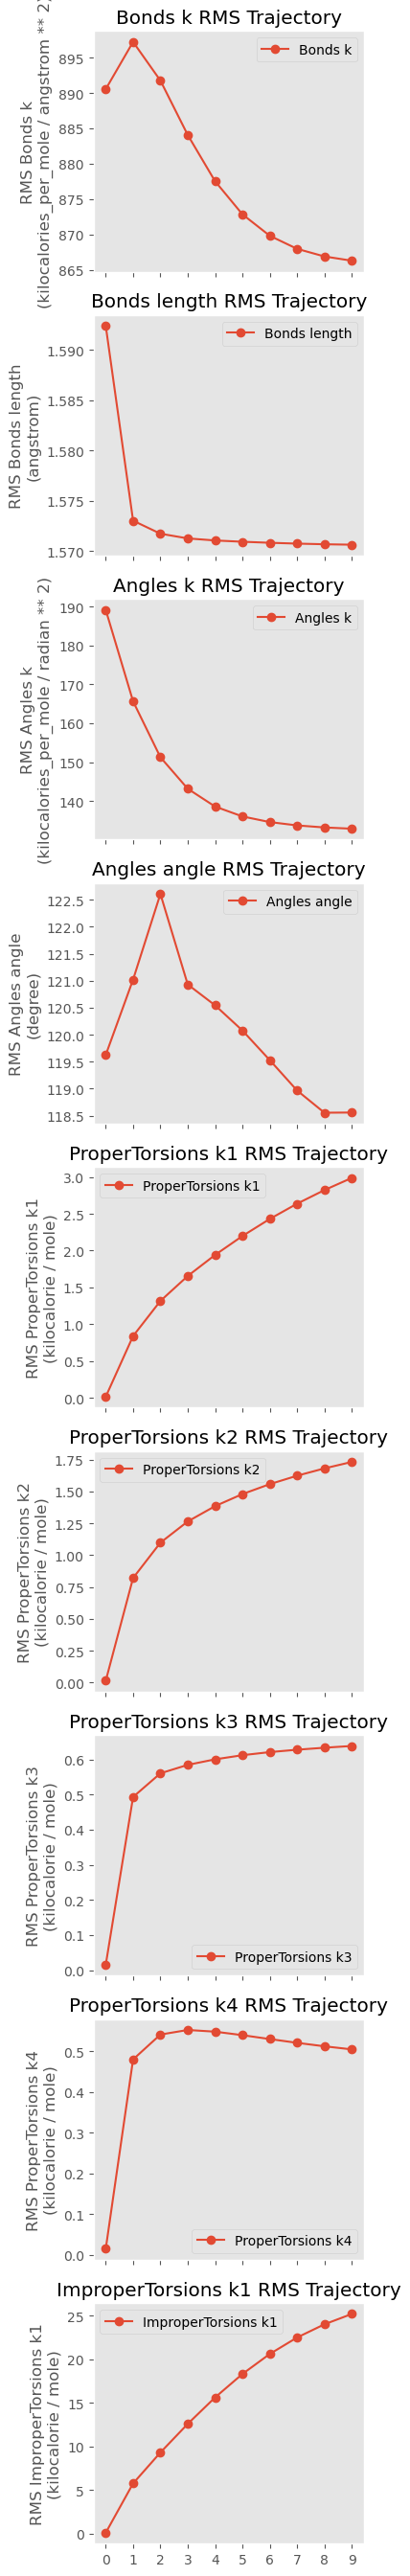

In [13]:
fig,axes = plot_param_trajectories(xml_ffs)
fig.savefig("linear_tor_no_reg_param_trajectories.png", dpi=300, bbox_inches="tight")

[PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-0.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-100.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-200.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-300.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-400.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-500.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-600.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-700.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-800.pt'), PosixPath('../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547/force-field-epoch-900.pt')]


  0%|          | 0/10 [00:00<?, ?it/s]2025-05-12 19:13:45.486 | INFO     | __main__:pt_ff_to_off_ff:80 - [1, 2, 3, 4]
2025-05-12 19:13:45.487 | INFO     | __main__:pt_ff_to_off_ff:81 - [<Quantity(0.009999666319519283, 'kilocalorie / mole')>, <Quantity(-0.009999960359764736, 'kilocalorie / mole')>, <Quantity(-0.009999888685637632, 'kilocalorie / mole')>, <Quantity(-0.009999903068328769, 'kilocalorie / mole')>]
2025-05-12 19:13:45.488 | INFO     | __main__:pt_ff_to_off_ff:82 - [*:1]-[#8:2]-[#8:3]-[*:4]
2025-05-12 19:13:45.489 | INFO     | __main__:pt_ff_to_off_ff:80 - [1, 2, 3, 4]
2025-05-12 19:13:45.489 | INFO     | __main__:pt_ff_to_off_ff:81 - [<Quantity(0.009999997625491246, 'kilocalorie / mole')>, <Quantity(-0.009999980491579713, 'kilocalorie / mole')>, <Quantity(0.009999999595977216, 'kilocalorie / mole')>, <Quantity(0.009999998260336818, 'kilocalorie / mole')>]
2025-05-12 19:13:45.489 | INFO     | __main__:pt_ff_to_off_ff:82 - [*:1]-[#8X2:2]-[#15:3]~[*:4]
2025-05-12 19:13:45.490 |

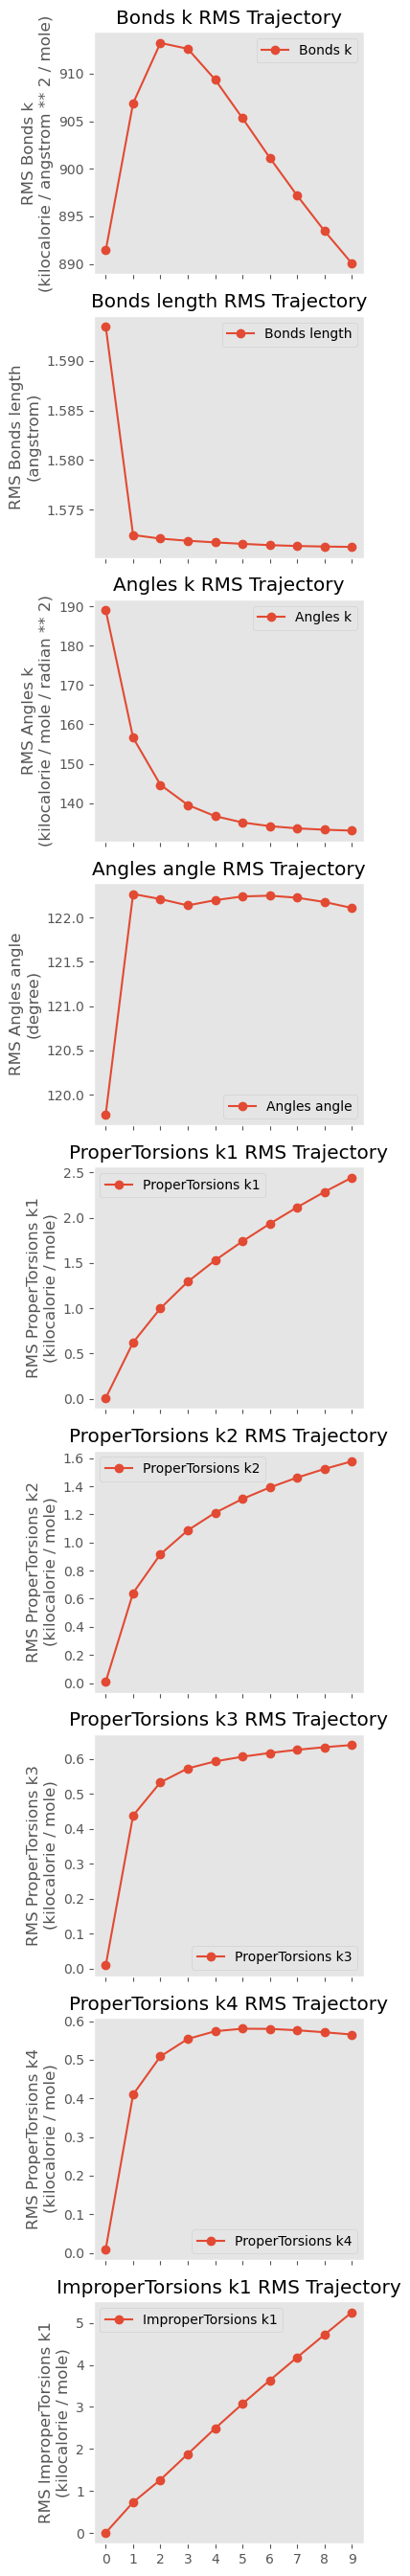

In [14]:
xml_ffs = get_xml_ffs(Path("../../../SPICE-SMEE/fit-v2/fits/test/fit-20250321-220547"), base_ff)
fig,axes = plot_param_trajectories(xml_ffs)
fig.savefig("expanded_tor_no_linear_harm_param_trajectories.png", dpi=300, bbox_inches="tight")

In [ ]:
xml_ffs = get_xml_ffs(Path("../../../SPICE-SMEE/fit-v3/fits/expanded_tor_linear/fit-20250418-135017/"), base_ff)

[PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-0.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-1.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-10.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-100.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-101.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-102.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-103.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-104.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-105.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-106.pt'), PosixPath('../fits/spice2_linearised_harmonics_improper_reg/force-field-epoch-107.pt'), PosixPath('../fits/spice2_linearised

  0%|          | 0/11 [00:00<?, ?it/s]2025-05-12 15:28:56.954 | INFO     | __main__:pt_ff_to_off_ff:54 - [1, 2, 3, 4]
2025-05-12 15:28:56.954 | INFO     | __main__:pt_ff_to_off_ff:55 - [<Quantity(-0.015384610161868569, 'kilocalorie / mole')>, <Quantity(0.015384615243081401, 'kilocalorie / mole')>, <Quantity(-0.015384614783062082, 'kilocalorie / mole')>, <Quantity(0.01538461534446484, 'kilocalorie / mole')>]
2025-05-12 15:28:56.955 | INFO     | __main__:pt_ff_to_off_ff:56 - [*:1]-,:[#6X3:2]=[#6X3:3]-,:[*:4]
2025-05-12 15:28:56.955 | INFO     | __main__:pt_ff_to_off_ff:54 - [1, 2, 3, 4]
2025-05-12 15:28:56.956 | INFO     | __main__:pt_ff_to_off_ff:55 - [<Quantity(0.0153846146522599, 'kilocalorie / mole')>, <Quantity(0.015384614645490065, 'kilocalorie / mole')>, <Quantity(0.01538461528203253, 'kilocalorie / mole')>, <Quantity(0.015384615151587065, 'kilocalorie / mole')>]
2025-05-12 15:28:56.956 | INFO     | __main__:pt_ff_to_off_ff:56 - [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
2025-05-12 15:28:56.95

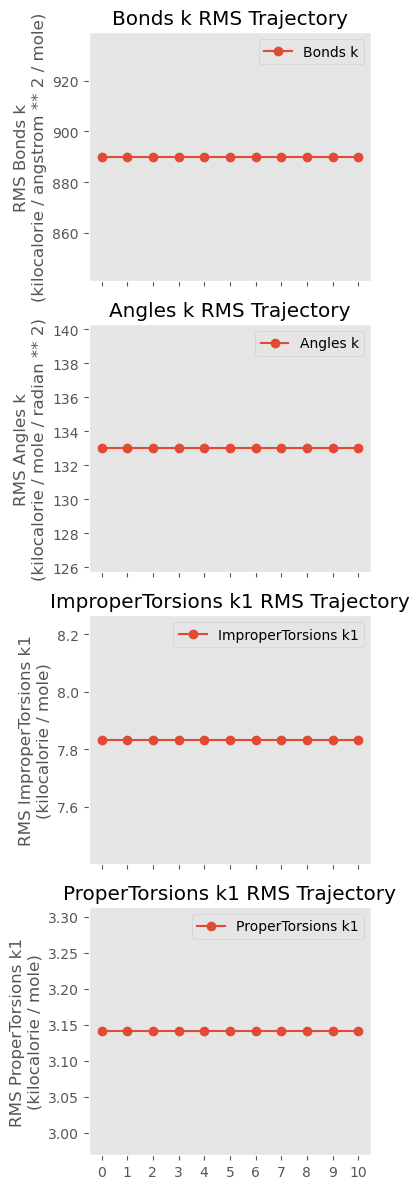

In [176]:
[(i, k) for i,(k,v) in enumerate(pot_types_and_param_keys)]

[(0, 'Bonds'), (1, 'Angles'), (2, 'ImproperTorsions'), (3, 'ProperTorsions')]

In [177]:
spice2_linear_harm.get_parameter_handler("ImproperTorsions").parameters[0].to_dict()["k1"]

31.50710763607608 <Unit('kilocalorie / mole')>

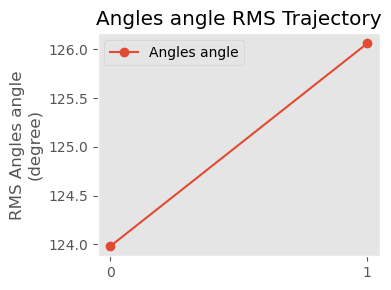

In [178]:
plot_param_trajectories_on_axes([off1, off2], [("Angles", "angle")])

In [52]:
get_rmse_param_values([ff, ff], "ProperTorsions", "k1")

(<Unit('kilocalorie / mole')>, array([1.78709364, 1.78709364]))

In [30]:
potential_type = "ProperTorsions"
parameter_key = "k1"
params = ff.get_parameter_handler(potential_type).parameters
param_names = [f"{p.id}_{parameter_key}" for p in params]
param_vals_with_units = [p.to_dict()[parameter_key] for p in params]
param_units = units.unit.degrees if potential_type == "Angles" and parameter_key == "angle" else param_vals_with_units[0].units
param_vals_unitless = np.array([float(v / param_units) for v in param_vals_with_units], dtype=np.float64)


In [26]:
params[0].to_dict()["k1"]

0.2042684902198 <Unit('kilocalorie / mole')>

In [19]:
param_names

NameError: name 'param_names' is not defined

In [43]:
get_param_values(ff, "ProperTorsions", "k1")

(['t1_k1',
  't2_k1',
  't3_k1',
  't4_k1',
  't5_k1',
  't6_k1',
  't7_k1',
  't8_k1',
  't9_k1',
  't10_k1',
  't11_k1',
  't12_k1',
  't13_k1',
  't14_k1',
  't15_k1',
  't16_k1',
  't17_k1',
  't20_k1',
  't18_k1',
  't19_k1',
  't21_k1',
  't22_k1',
  't23_k1',
  't24_k1',
  't25_k1',
  't26_k1',
  't27_k1',
  't28_k1',
  't29_k1',
  't30_k1',
  't31_k1',
  't32_k1',
  't33_k1',
  't34_k1',
  't35_k1',
  't36_k1',
  't37_k1',
  't38_k1',
  't39_k1',
  't40_k1',
  't41_k1',
  't42_k1',
  't43_k1',
  't44_k1',
  't45_k1',
  't46_k1',
  't47_k1',
  't48_k1',
  't49_k1',
  't50_k1',
  't51_k1',
  't52_k1',
  't54_k1',
  't55_k1',
  't56_k1',
  't57_k1',
  't58_k1',
  't59_k1',
  't60_k1',
  't61_k1',
  't62_k1',
  't63_k1',
  't64_k1',
  't65_k1',
  't66_k1',
  't67_k1',
  't68_k1',
  't69_k1',
  't70_k1',
  't71_k1',
  't72_k1',
  't73_k1',
  't74_k1',
  't75_k1',
  't76_k1',
  't77_k1',
  't78_k1',
  't79_k1',
  't80_k1',
  't81_k1',
  't82_k1',
  't83_k1',
  't84_k1',
  't85_k1',
 